In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import sys
import numpy as np
import torch 
import lightning
import matplotlib.pyplot as plt
from networks import *
from torchsummary import summary
from utils import *
import random
import tqdm
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader
import pandas as pd
import time
torch.set_float32_matmul_precision("medium")
%load_ext autoreload
%autoreload 2

# test pipeline

In [ ]:
#initialize datasets
batchsize=16
path_sparse = '/data-pool/data_no_backup/ga63cun/PE/64/'
path_gt = '/data-pool/data_no_backup/ga63cun/PE/4095/'
save_path = "./model_weights/2DUNet/"

df_train = pd.read_csv("./Test_allImages.csv") #I just put in the test csv path here
df_val = pd.read_csv("./Test_allImages.csv") #I just put in the test csv path here

#initialize training parameters
lr = 5e-5
weight_decay = 1e-2
optimizer_algo = "AdamW"
optimizer_params={"weight_decay": weight_decay}
scheduler_algo = "StepLR"
scheduler_params = {"step_size":4, "gamma":0.9}
patch_size = (256, 256)
ww = 3_000
wl = 0

In [3]:
dataset_train = SparseDataset(df = df_train, 
                 path_sparse = path_sparse, 
                 path_gt = path_gt, 
                 augmentation = True, 
                 image_size=patch_size, 
                 ww=ww, 
                 wl=wl
                             )

dataset_val = SparseDataset(df = df_val, 
                 path_sparse = path_sparse, 
                 path_gt = path_gt, 
                 augmentation = False, 
                 image_size=patch_size, 
                 ww=ww, 
                 wl=wl
                           )

dataloader_train = DataLoader(dataset_train, batch_size=batchsize, num_workers=4, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batchsize, num_workers=4, shuffle=False)

In [4]:
#test dataloader

batch_sparse_train, batch_gt_train, batch_label_train = next(iter(dataloader_train))
batch_sparse_val, batch_gt_val, batch_label_val = next(iter(dataloader_val))

tensor([0, 1, 0, 1])
tensor([0, 0, 0, 0])


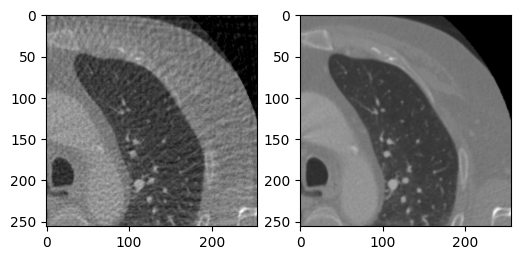

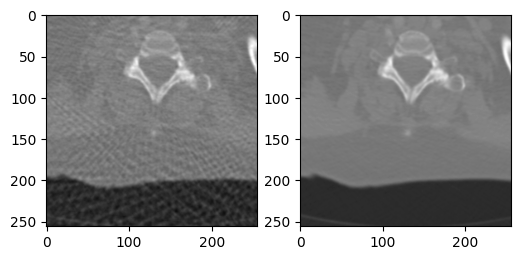

In [5]:
k=0

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
print(batch_label_train[k])
ax[0].imshow(batch_sparse_train[k, 0], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(batch_gt_train[k, 0], cmap='gray', vmin=0, vmax=1)

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
print(batch_label_val[k])
ax[0].imshow(batch_sparse_val[k, 0], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(batch_gt_val[k, 0], cmap='gray', vmin=0, vmax=1)


In [4]:
#initialize model
unet = UNet(n_channels=1, n_classes=1, bilinear=True).float()

In [4]:
model = LitModel(unet=unet, 
                 optimizer_algo=optimizer_algo, 
                 optimizer_params=optimizer_params,
                 loss = nn.MSELoss(reduction='mean'), 
                 lr = lr,
                 scheduler_algo="StepLR",
                 scheduler_params=scheduler_params
                   )

lr_monitor = L.pytorch.callbacks.LearningRateMonitor(logging_interval='epoch')
tblogger = TensorBoardLogger(save_path)
csvlogger = CSVLogger(save_path, version=tblogger.version)
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=3)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=7)

trainer = L.Trainer(logger=[csvlogger, tblogger], 
                    callbacks=[lr_monitor, checkpoint, early_stopping], 
                    max_epochs=400)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/usr/local/lib/python3.8/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-09-12 07:20:56.365242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 07:20:57.099611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_D

Finding best initial lr:   0%|          | 0/150 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=150` reached.
Learning rate set to 6.730674999305024e-05
Restoring states from the checkpoint path at /users/Thalhammer/3DCNN_ArtifactReduction/.lr_find_768d76ad-00df-4857-8308-081e04ae221f.ckpt
Restored all states from the checkpoint at /users/Thalhammer/3DCNN_ArtifactReduction/.lr_find_768d76ad-00df-4857-8308-081e04ae221f.ckpt


6.730674999305024e-05


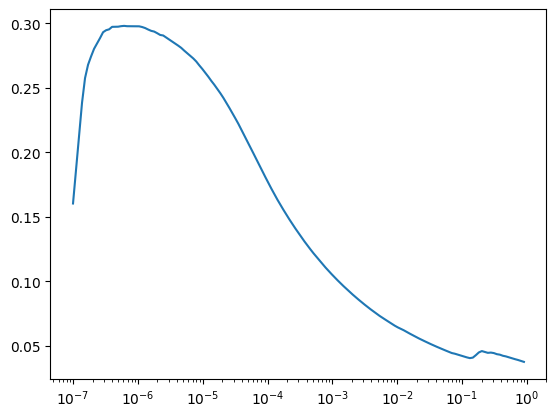

In [8]:
# find learning rate
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, dataloader_train, min_lr=1e-7, max_lr=9e-1, num_training=150, early_stop_threshold=50)
print(lr_finder.suggestion())
plt.plot(lr_finder.results["lr"], lr_finder.results["loss"])
plt.xscale("log")

In [10]:
#test if model overfits on 2 batches
trainer = L.Trainer(logger=[csvlogger, tblogger], 
                    callbacks=[lr_monitor, checkpoint, early_stopping], 
                    max_epochs=400, overfit_batches=2)

trainer.fit(model, dataloader_train, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory ./model_weights/2DUNet/lightning_logs/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | unet | UNet    | 17.3 M
1 | loss | MSELoss | 0     
---------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.047    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [2]:
#load model from checkpoint
unet = UNet(n_channels=1, n_classes=1, bilinear=True).float()
model = LitModel.load_from_checkpoint("/vault3/machine_learning/3CDNN_ArtifactReduction/model_weights/2DUNet/lightning_logs/version_3/checkpoints/epoch=38-step=34164.ckpt", unet=unet)
model.eval()
print()

# test 3D approach

In [ ]:
test_vol = np.load("/vault3/machine_learning/datasets/public/RSNA_PE/train_sorted/0/0.npy")
test_vol_sparse = np.load("/vault3/machine_learning/datasets/public/RSNA_PE/train_sorted_sparse/cone/128_angles/0/0.npy")
print(test_vol.dtype, test_vol.shape, test_vol.nbytes*1e-9)

int16 (354, 512, 512) 0.185597952


In [ ]:
#save all features
#load model from checkpoint
unet = UNet(n_channels=1, n_classes=1, bilinear=True).float()
model = LitModel.load_from_checkpoint("/vault3/machine_learning/3CDNN_ArtifactReduction/model_weights/2DUNet/lightning_logs/version_3/checkpoints/epoch=38-step=34164.ckpt", unet=unet)
model.eval()
print()
ww = 3_000
wl = 0
batchsize = 128
model = model.cuda()
path = "/vault3/machine_learning/datasets/public/RSNA_PE/train_sorted_sparse/cone/128_angles/"
filenames = os.listdir(path)
filenames[:100]

In [7]:
summary(model, (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             576
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,864
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
        DoubleConv-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,728
      BatchNorm2d-10        [-1, 128, 256, 256]             256
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,456
      BatchNorm2d-13        [-1, 128, 256, 256]             256
             ReLU-14        [-1, 128, 2

In [6]:

filename = filenames[0]
test_vol_sparse = np.load(f"/vault3/machine_learning/datasets/public/RSNA_PE/train_sorted_sparse/cone/128_angles/{filename}/{filename}.npy", mmap_mode="c")
z = test_vol_sparse.shape[0]
x1_list = []
x2_list = []
x3_list = []
x4_list = []
x5_list = []
start = time.time()
for k in tqdm.tqdm(range(0, z, batchsize)):
    inpt = torch.from_numpy(test_vol_sparse[k:k+batchsize, None, :256, :256]).cuda()
    inpt = window(inpt, wl=wl, ww=ww)
    with torch.no_grad():
        x1 = model.unet.inc(inpt)
        x2 = model.unet.down1(x1)
        x3 = model.unet.down2(x2)
        x4 = model.unet.down3(x3)
        x5 = model.unet.down4(x4)

    #y = model.unet.up4(model.unet.up3(model.unet.up2(model.unet.up1(x5, x4), x3), x2), x1)
    #final = model.unet.outc(y) + inpt
    #final = final*ww - ww/2

    x1_list.append(x1.detach().cpu().half())
    x2_list.append(x2.detach().cpu().half())
    x3_list.append(x3.detach().cpu().half())
    x4_list.append(x4.detach().cpu().half())
    x5_list.append(x5.detach().cpu().half())
    
    #fig, axes = plt.subplots(1, 3, figsize=(24, 12))
    #axes[0].imshow(test_vol[k], cmap='gray', vmin=-250, vmax=350)
    #axes[1].imshow(test_vol_sparse[k], cmap='gray', vmin=-250, vmax=350)
    #axes[2].imshow(final.detach().cpu().numpy().squeeze()[0], cmap='gray', vmin=-250, vmax=350)


x1_stack = torch.swapaxes(torch.cat(x1_list, axis=0), 0, 1)
x2_stack = torch.swapaxes(torch.cat(x2_list, axis=0), 0, 1)
x3_stack = torch.swapaxes(torch.cat(x3_list, axis=0), 0, 1)
x4_stack = torch.swapaxes(torch.cat(x4_list, axis=0), 0, 1)
x5_stack = torch.swapaxes(torch.cat(x5_list, axis=0), 0, 1)

np.save(path + f"/{filename}/{filename}_x1.npy", x1_stack)
np.save(path + f"/{filename}/{filename}_x2.npy", x2_stack)
np.save(path + f"/{filename}/{filename}_x3.npy", x3_stack)
np.save(path + f"/{filename}/{filename}_x4.npy", x4_stack)
np.save(path + f"/{filename}/{filename}_x5.npy", x5_stack)

print (time.time()-start)

100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


5.3921356201171875


In [16]:
path_save = "/data-pool/data_no_backup/ga63cun/PE/3DCNN/"
start = time.time()
os.mkdir(path_save + f"/{filename}/")
np.savez_compressed(path_save + f"/{filename}/{filename}_x1.npz", x1_stack)
np.savez_compressed(path_save + f"/{filename}/{filename}_x2.npz", x2_stack)
np.savez_compressed(path_save + f"/{filename}/{filename}_x3.npz", x3_stack)
np.savez_compressed(path_save + f"/{filename}/{filename}_x4.npz", x4_stack)
np.savez_compressed(path_save + f"/{filename}/{filename}_x5.npz", x5_stack)
print(time.time() - start)
#865.0923819541931

865.0923819541931


In [27]:
start = time.time()
x1_load = np.load(path_save + f"/{filename}/{filename}_x1.npz")
x2_load = np.load(path_save + f"/{filename}/{filename}_x2.npz")
x3_load = np.load(path_save + f"/{filename}/{filename}_x3.npz")
x4_load = np.load(path_save + f"/{filename}/{filename}_x4.npz")
x5_load = np.load(path_save + f"/{filename}/{filename}_x5.npz")
print(x1_load["arr_0"].shape, x2_load["arr_0"].shape, x3_load["arr_0"].shape, x4_load["arr_0"].shape, x5_load["arr_0"].shape)
print(time.time() - start)
#85.7354531288147

(64, 354, 512, 512) (128, 354, 256, 256) (256, 354, 128, 128) (512, 354, 64, 64) (512, 354, 32, 32)
85.7354531288147


In [30]:
path_save = "/data-pool/data_no_backup/ga63cun/PE/3DCNN/"
start = time.time()
np.save(path_save + f"/{filename}/{filename}_x1.npy", x1_stack)
np.save(path_save + f"/{filename}/{filename}_x2.npy", x2_stack)
np.save(path_save + f"/{filename}/{filename}_x3.npy", x3_stack)
np.save(path_save + f"/{filename}/{filename}_x4.npy", x4_stack)
np.save(path_save + f"/{filename}/{filename}_x5.npy", x5_stack)
print(time.time() - start)
#865.0923819541931

238.77866339683533


In [4]:
path_save = "/data-pool/data_no_backup/ga63cun/PE/3DCNN/"
filename = "0"
start = time.time()
x1_load = np.load(path_save + f"/{filename}/{filename}_x1.npy")
x2_load = np.load(path_save + f"/{filename}/{filename}_x2.npy")
x3_load = np.load(path_save + f"/{filename}/{filename}_x3.npy")
x4_load = np.load(path_save + f"/{filename}/{filename}_x4.npy")
x5_load = np.load(path_save + f"/{filename}/{filename}_x5.npy")
print(x1_load.shape, x2_load.shape, x3_load.shape, x4_load.shape, x5_load.shape)
print(time.time() - start)

(64, 354, 512, 512) (128, 354, 256, 256) (256, 354, 128, 128) (512, 354, 64, 64) (512, 354, 32, 32)
3.1847951412200928


In [ ]:
#save as one file

start = time.time()
np.savez_compressed(path_save + f"/{filename}/{filename}_latent.npz", x1=x1_stack, x2=x2_stack, x3=x3_stack, x4=x4_stack, x5=x5_stack)
#np.savez_compressed(path + f"/{filename}/{filename}_x2.npz", x2_stack)
#np.savez_compressed(path + f"/{filename}/{filename}_x3.npz", x3_stack)
#np.savez_compressed(path + f"/{filename}/{filename}_x4.npz", x4_stack)
#np.savez_compressed(path + f"/{filename}/{filename}_x5.npz", x5_stack)
print(time.time() - start)
#927.3237977027893


In [ ]:

start = time.time()
latent_load = np.load(path + f"/{filename}/{filename}_latent.npz", mmap_mode="c")
print(latent_load["x1"].shape, latent_load["x2"].shape, latent_load["x3"].shape, latent_load["x4"].shape, latent_load["x5"].shape)
print(time.time() - start)
#0.6310434341430664

In [8]:
import h5py
with h5py.File(path + f"/{filename}/{filename}_latent.hdf5", 'w') as hf:
    hf.create_dataset("x1_stack",  data=x1_stack)
    hf.create_dataset("x2_stack",  data=x2_stack)
    hf.create_dataset("x3_stack",  data=x3_stack)
    hf.create_dataset("x4_stack",  data=x4_stack)
    hf.create_dataset("x5_stack",  data=x5_stack)

In [ ]:
print(x1_stack.shape, x1_stack.nbytes*1e-9)

(64, 354, 512, 512) 11.878268928


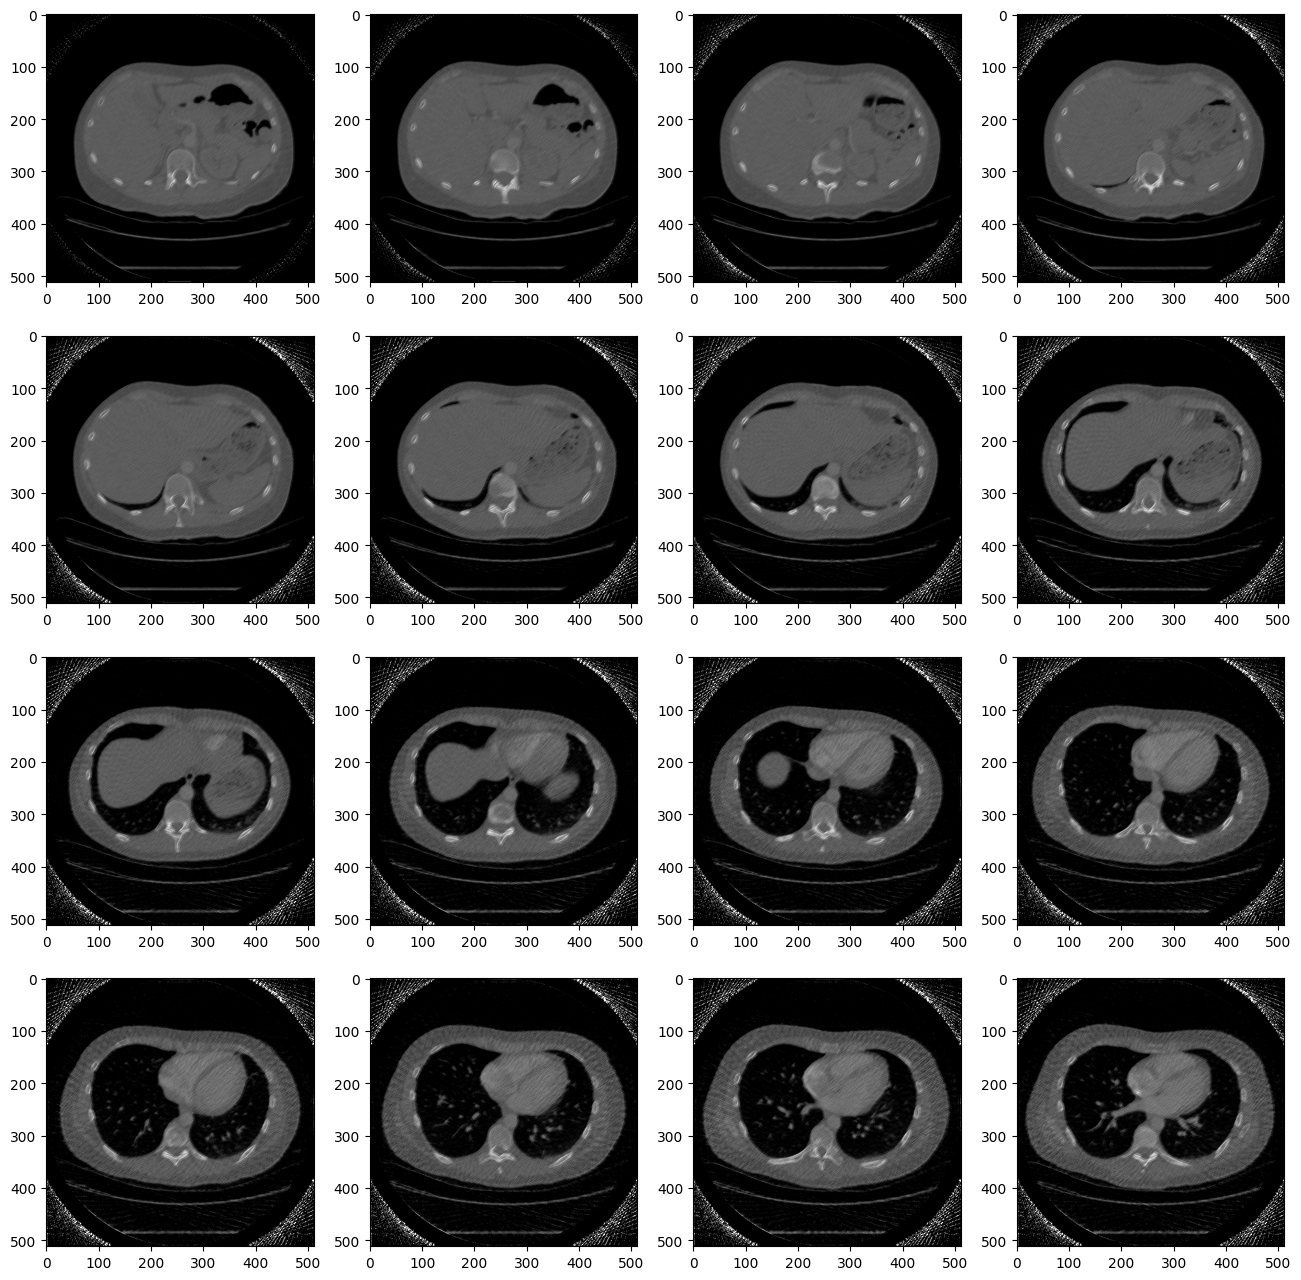

In [25]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for k, ax in enumerate(fig.axes):
    ax.imshow(x1_stack_rek[1, k*10], cmap="gray", vmin=0, vmax=2)

 

# check gpu usage

In [3]:
#load 3D model
from torchsummary import summary
decoder3D = Decoder3D(in_channels=1, num_classes=1, bilinear=False, norm="GN", norm_params={"num_groups":1}).float().cuda()

In [3]:
#summary(decoder3D, [[1, 202, 512, 512], [64, 202, 512, 512], [128, 202, 256, 256], [256, 202, 128, 128], [512, 202, 64, 64], [512, 202, 32, 32]])


In [30]:
test_vol = np.load("/vault3/machine_learning/datasets/public/RSNA_PE/train_sorted/0/0.npy")
test_vol_sparse = np.load("/vault3/machine_learning/datasets/public/RSNA_PE/train_sorted_sparse/cone/128_angles/0/0.npy")

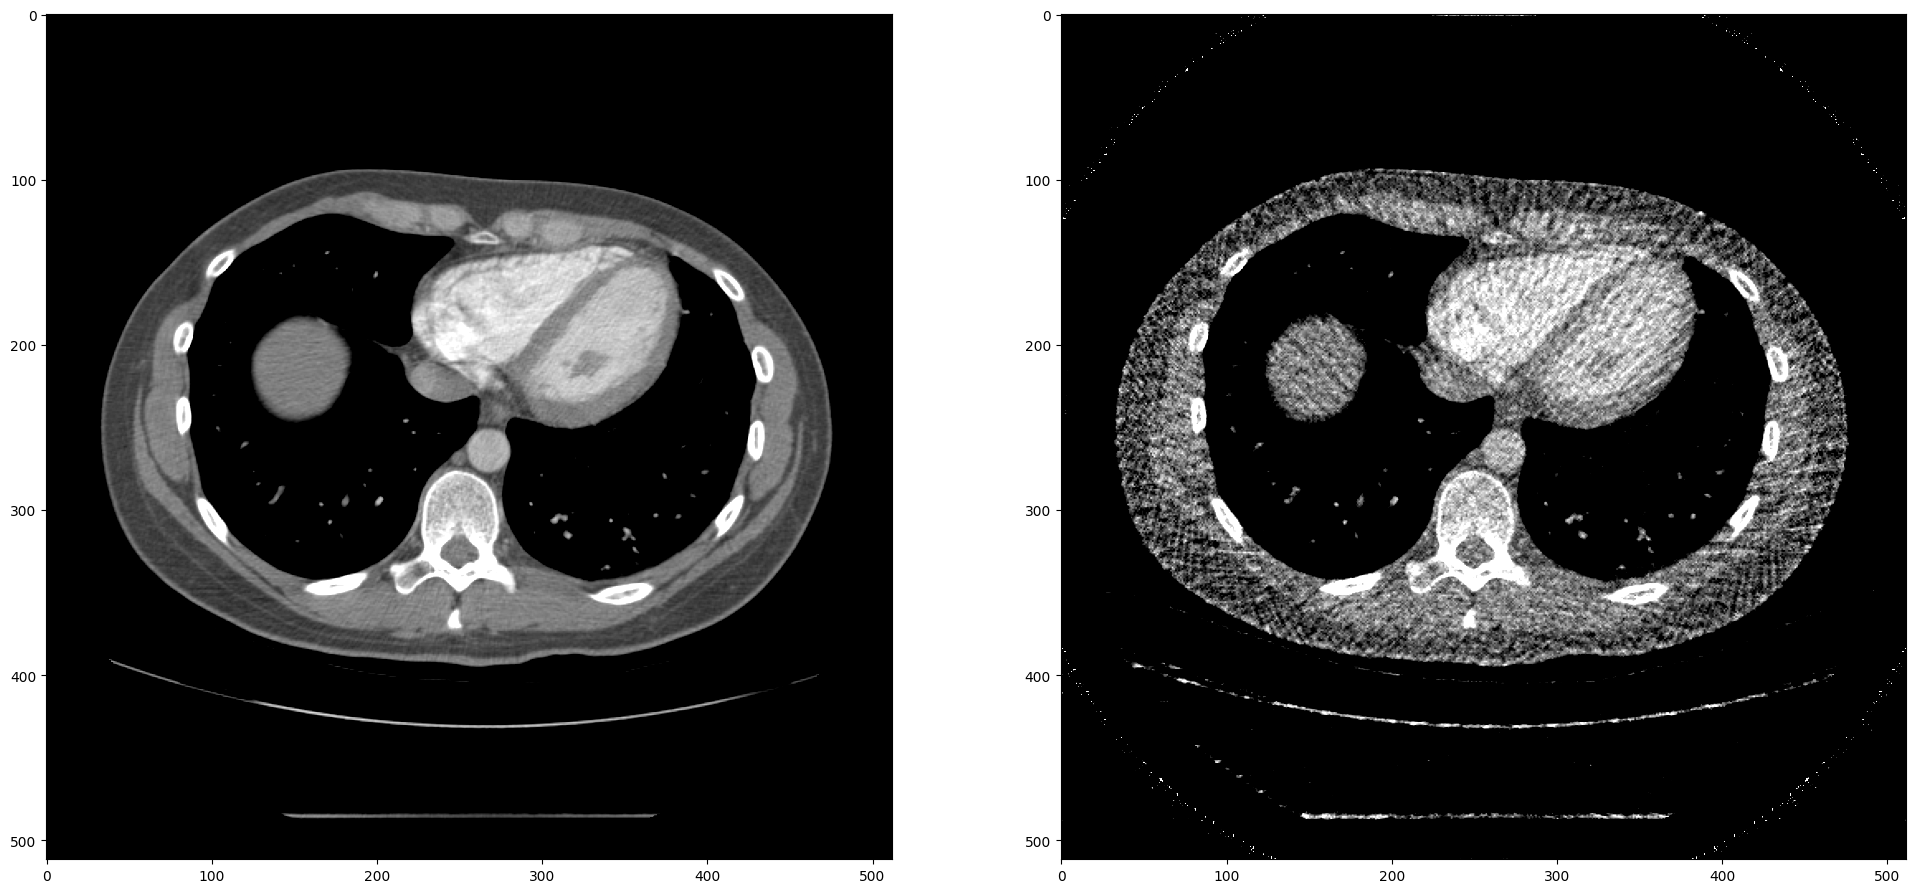

In [38]:
for k in range(100, 101):
    fix, axes = plt.subplots(1, 2, figsize=(24, 12))
    axes[0].imshow(test_vol[k], cmap='gray', vmin=-250, vmax=350)
    axes[1].imshow(test_vol_sparse[k], cmap='gray', vmin=-250, vmax=350)

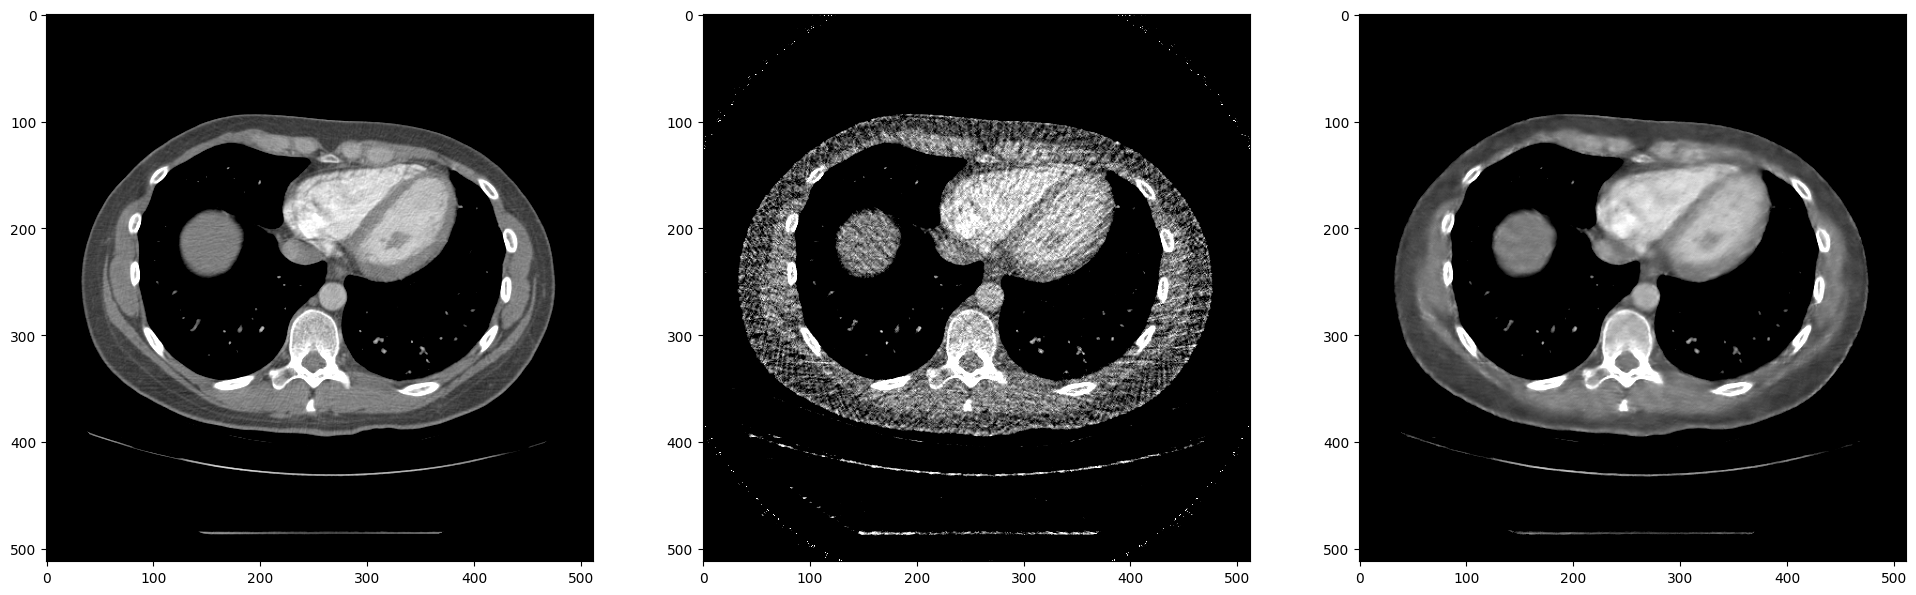

In [19]:
x1 = model.unet.inc(inpt)
x2 = model.unet.down1(x1)
x3 = model.unet.down2(x2)
x4 = model.unet.down3(x3)
x5 = model.unet.down4(x4)
y = model.unet.up4(model.unet.up3(model.unet.up2(model.unet.up1(x5, x4), x3), x2), x1)
final = model.unet.outc(y) + inpt
final = final*ww - ww/2

fix, axes = plt.subplots(1, 3, figsize=(24, 12))
axes[0].imshow(test_vol[k], cmap='gray', vmin=-250, vmax=350)
axes[1].imshow(test_vol_sparse[k], cmap='gray', vmin=-250, vmax=350)
axes[2].imshow(final.detach().cpu().numpy().squeeze(), cmap='gray', vmin=-250, vmax=350)

In [5]:
for elem in inpt_list:
    print(elem.size())

torch.Size([1, 1, 202, 512, 512])
torch.Size([1, 64, 202, 512, 512])
torch.Size([1, 128, 202, 256, 256])
torch.Size([1, 256, 202, 128, 128])
torch.Size([1, 512, 202, 64, 64])
torch.Size([1, 512, 202, 32, 32])


# check size

In [2]:
#load 3D model
from torchsummary import summary
decoder3D = Decoder3D(in_channels=1, num_classes=1, bilinear=False).float().cuda()

In [3]:
x1 = np.load("/data-pool/data_no_backup/ga63cun/PE/3DCNN/1/1_x1.npy")
x2 = np.load("/data-pool/data_no_backup/ga63cun/PE/3DCNN/1/1_x2.npy")
x3 = np.load("/data-pool/data_no_backup/ga63cun/PE/3DCNN/1/1_x3.npy")
x4 = np.load("/data-pool/data_no_backup/ga63cun/PE/3DCNN/1/1_x4.npy")
x5 = np.load("/data-pool/data_no_backup/ga63cun/PE/3DCNN/1/1_x5.npy")
inpt = np.load("/vault3/machine_learning/datasets/public/RSNA_PE/train_sorted/1/1.npy")
inpt = inpt[None]
inpt_list = [torch.from_numpy(elem[None, :, :elem.shape[1]//2, :elem.shape[2]//2, :elem.shape[3]//2]).cuda().float() for elem in (inpt, x1, x2, x3, x4, x5)]

In [4]:
for elem in inpt_list:
    print(elem.size())

torch.Size([1, 1, 101, 256, 256])
torch.Size([1, 64, 101, 256, 256])
torch.Size([1, 128, 101, 128, 128])
torch.Size([1, 256, 101, 64, 64])
torch.Size([1, 512, 101, 32, 32])
torch.Size([1, 512, 101, 16, 16])


In [5]:
out = decoder3D(*inpt_list)

torch.Size([1, 1, 101, 256, 256]) torch.Size([1, 512, 101, 16, 16])
torch.Size([1, 512, 101, 16, 16])
inpt torch.Size([1, 512, 101, 16, 16])
out torch.Size([1, 512, 101, 32, 32]) res torch.Size([1, 512, 101, 32, 32])
torch.Size([1, 512, 101, 32, 32])
inpt torch.Size([1, 512, 101, 32, 32])
out torch.Size([1, 256, 101, 64, 64]) res torch.Size([1, 256, 101, 64, 64])
torch.Size([1, 256, 101, 64, 64])
inpt torch.Size([1, 256, 101, 64, 64])
out torch.Size([1, 128, 101, 128, 128]) res torch.Size([1, 128, 101, 128, 128])
torch.Size([1, 128, 101, 128, 128])
inpt torch.Size([1, 128, 101, 128, 128])
out torch.Size([1, 64, 101, 256, 256]) res torch.Size([1, 64, 101, 256, 256])
torch.Size([1, 1, 101, 256, 256])


In [77]:
out.size(), inp.size()

(torch.Size([1, 512, 100, 32, 32]), torch.Size([1, 512, 100, 16, 16]))

In [6]:
summary(decoder3D, [[1, 1, 256, 256], [64, 101, 256, 256], [128, 101, 128, 128], [256, 101, 64, 64], [512, 101, 32, 32], [512, 101, 16, 16]])

torch.Size([2, 1, 1, 256, 256]) torch.Size([2, 512, 101, 16, 16])
torch.Size([2, 512, 101, 16, 16])
inpt torch.Size([2, 512, 101, 16, 16])
out torch.Size([2, 512, 101, 32, 32]) res torch.Size([2, 512, 101, 32, 32])
torch.Size([2, 512, 101, 32, 32])
inpt torch.Size([2, 512, 101, 32, 32])
out torch.Size([2, 256, 101, 64, 64]) res torch.Size([2, 256, 101, 64, 64])
torch.Size([2, 256, 101, 64, 64])
inpt torch.Size([2, 256, 101, 64, 64])
out torch.Size([2, 128, 101, 128, 128]) res torch.Size([2, 128, 101, 128, 128])
torch.Size([2, 128, 101, 128, 128])
inpt torch.Size([2, 128, 101, 128, 128])
out torch.Size([2, 64, 101, 256, 256]) res torch.Size([2, 64, 101, 256, 256])
torch.Size([2, 1, 101, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 512, 101, 16, 16]       7,078,400
       BatchNorm3d-2     [-1, 512, 101, 16, 16]           1,024
              ReLU-3     [-1, 512, 10

# Check training 3Decoder

In [2]:
#initialize datasets
batchsize=1
path = '/data-pool/data_no_backup/ga63cun/PE/3DCNN//'
save_path = "./model_weights/3Decoder/"

df_train = pd.read_csv("./train.csv") #I just put in the test csv path here
df_train_filtered = df_train[df_train["nr_slices"] > 64]
#initialize training parameters
lr = 1e-4
weight_decay = 1e-2
optimizer_algo = "AdamW"
optimizer_params={"weight_decay": weight_decay}
scheduler_algo = "ReduceLROnPlateau"
scheduler_params = {"patience":3, "factor":0.5}
ww = 3_000
wl = 0
print()
df_train_filtered[50:60]

,Unnamed: 0,filename,nr_slices
50,50,50,206
51,51,51,340
52,52,52,241
53,53,53,211
54,54,54,276
55,55,55,209
56,56,56,81
57,57,57,186
58,58,58,424
59,59,59,234


In [9]:
dataset_train = SparseDataset3D(df = df_train_filtered, 
                 path = path, 
                 augmentation = False, 
                 ww=ww, 
                 wl=wl, 
                 downsample=False,
                 size=(64, 512, 512),
                 )

dataloader_train = DataLoader(dataset_train, batch_size=batchsize, num_workers=2, shuffle=True)


In [10]:
for batch in dataloader_train:
    break
fullview, inpt, x1, x2, x3, x4, x5 = batch

In [11]:
for elem in [fullview, inpt, x1, x2, x3, x4, x5]:
    print(elem.size())

torch.Size([1, 1, 64, 512, 512])
torch.Size([1, 1, 64, 512, 512])
torch.Size([1, 64, 64, 512, 512])
torch.Size([1, 128, 64, 256, 256])
torch.Size([1, 256, 64, 128, 128])
torch.Size([1, 512, 64, 64, 64])
torch.Size([1, 512, 64, 32, 32])


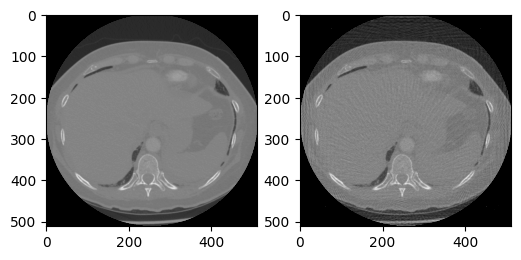

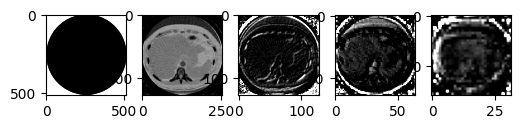

In [6]:
k=5

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(fullview[0, 0, k], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(inpt[0, 0, k], cmap='gray', vmin=0, vmax=1)

fig, ax = plt.subplots(1, 5, figsize=(6, 3))
ax[0].imshow(x1[0, 0, k], cmap='gray', vmin=0, vmax=1)
ax[1].imshow(x2[0, 0, k], cmap='gray', vmin=0, vmax=1)
ax[2].imshow(x3[0, 0, k], cmap='gray', vmin=0, vmax=1)
ax[3].imshow(x4[0, 0, k], cmap='gray', vmin=0, vmax=1)
ax[4].imshow(x5[0, 0, k], cmap='gray', vmin=0, vmax=1)

In [7]:
decoder3D = Decoder3D(in_channels=1, num_classes=1, bilinear=False).half()

In [8]:
model = LitModel3D(network=decoder3D, 
                 optimizer_algo=optimizer_algo, 
                 optimizer_params=optimizer_params,
                 loss = nn.MSELoss(reduction='mean'), 
                 lr = lr,
                 scheduler_algo=scheduler_algo,
                 scheduler_params=scheduler_params
                   )

lr_monitor = L.pytorch.callbacks.LearningRateMonitor(logging_interval='epoch')
tblogger = TensorBoardLogger(save_path)
csvlogger = CSVLogger(save_path, version=tblogger.version)
checkpoint = ModelCheckpoint(monitor="train_loss", mode="min", save_top_k=3)
early_stopping = EarlyStopping(monitor="train_loss", mode="min", patience=5)

trainer = L.Trainer(logger=[csvlogger, tblogger], 
                    callbacks=[lr_monitor, checkpoint, early_stopping], 
                    max_epochs=400,precision="bf16-mixed")

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/usr/local/lib/python3.8/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory ./model_weights/3Decoder/lightning_logs/version_13/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]
Exception ignored in: <function _releaseLock at 0x7ffa4ee263a0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
LR finder stopped early after 1 steps due to diverging loss.
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
Restoring states from the checkpoint path at /users/Thalhammer/3DCNN_ArtifactReduction/.lr_find_2843f644-0ff9-4528-acab-035cceb7a6e7.ckpt
Restored all states from the checkpoint at /users/Thalhammer/3DCNN_ArtifactReduction/.lr_find_2843f644-0ff9-4528-acab-035cceb7a6e7.ckpt
Failed to compute suggestion for learning rat

None


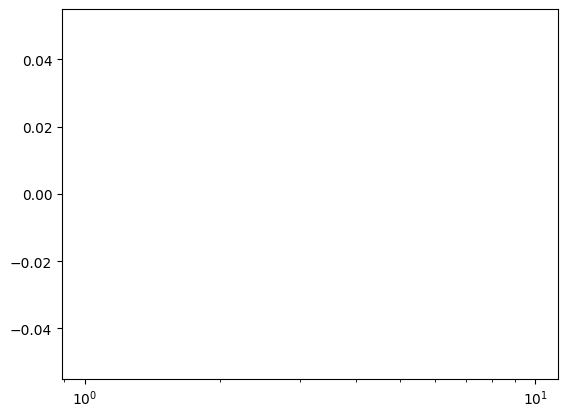

In [19]:
# find learning rate
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, dataloader_train, min_lr=1e-6, max_lr=1e-2, num_training=50, early_stop_threshold=50)
print(lr_finder.suggestion())
plt.plot(lr_finder.results["lr"], lr_finder.results["loss"])
plt.xscale("log")

In [9]:
#test if model overfits on 2 batches
trainer = L.Trainer(logger=[csvlogger, tblogger], 
                    callbacks=[lr_monitor, checkpoint, early_stopping], 
                    max_epochs=400, overfit_batches=1)

trainer.fit(model, dataloader_train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
/usr/local/lib/python3.8/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-11-18 00:28:56.613831: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 00:28:57.455034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name | Type      | Params
-----------------------------------
0 | net  | Decoder3D | 47.6 M
1 | loss | MSELoss   | 0   

Training: |          | 0/? [00:00<?, ?it/s]

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

RuntimeError: DataLoader worker (pid(s) 1613599) exited unexpectedly

# Check encoder module

In [2]:
#initialize datasets
batchsize=1
path = '/data-pool/data_no_backup/ga63cun/PE/3DCNN//'
save_path = "./model_weights/3Decoder/"

df_train = pd.read_csv("./train.csv") #I just put in the test csv path here
df_train_filtered = df_train[df_train["nr_slices"] > 128]
#initialize training parameters
lr = 1e-4
weight_decay = 1e-2
optimizer_algo = "AdamW"
optimizer_params={"weight_decay": weight_decay}
scheduler_algo = "ReduceLROnPlateau"
scheduler_params = {"patience":3, "factor":0.5}
ww = 3_000
wl = 0

In [3]:
dataset_train = SparseDataset3D(df = df_train_filtered, 
                 path = path, 
                 augmentation = False, 
                 ww=ww, 
                 wl=wl, 
                 downsample=False,
                 size=(128, 512, 512),
                 )

dataloader_train = DataLoader(dataset_train, batch_size=batchsize, num_workers=0, shuffle=True)

In [4]:
fullview, inpt, x1, x2, x3, x4, x5 = next(iter(dataloader_train))

In [5]:
decoder = Decoder3D_EncodeZ(in_channels=1, num_classes=1, bilinear=False, norm="GN", norm_params={"num_groups":4}, residual=False)


In [6]:
out = decoder(inpt.float(), x1.float(), x2.float(), x3.float(), x4.float(), x5.float())

x5: torch.Size([1, 512, 128, 32, 32])
x5 encoded: torch.Size([1, 512, 8, 32, 32])
out bottleneck: torch.Size([1, 512, 8, 32, 32])
x4: torch.Size([1, 512, 128, 64, 64])
x4 encoded: torch.Size([1, 512, 16, 64, 64])
inside upconv - size inpt torch.Size([1, 512, 8, 32, 32])
inside upconv - size residual torch.Size([1, 512, 16, 64, 64])
inside upconv - size out upconv torch.Size([1, 512, 16, 64, 64])
out block4: torch.Size([1, 512, 16, 64, 64])
inside upconv - size inpt torch.Size([1, 512, 16, 64, 64])
inside upconv - size residual torch.Size([1, 256, 32, 128, 128])
inside upconv - size out upconv torch.Size([1, 256, 32, 128, 128])
inside upconv - size inpt torch.Size([1, 256, 32, 128, 128])
inside upconv - size residual torch.Size([1, 128, 64, 256, 256])
inside upconv - size out upconv torch.Size([1, 128, 64, 256, 256])
inside upconv - size inpt torch.Size([1, 128, 64, 256, 256])
inside upconv - size residual torch.Size([1, 64, 128, 512, 512])
inside upconv - size out upconv torch.Size([1,

In [10]:
for elem in out:
    print(elem.size())

torch.Size([1, 128, 512, 512])
